In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost

%matplotlib inline

# Import data
data = pd.read_csv('../data/data_all_features.csv')
minimal_data = pd.read_csv('../data/data_selected_features.csv')
train_test_data = pickle.load(open("../data/train_test_data_all_features", "rb"))
minimal_train_test_data = pickle.load(open("../data/train_test_data_selected_features", "rb"))
model = pickle.load(open("../data/xgb_model_pickle_v2", "rb"))

# Get samples
sample_data = train_test_data['X_test'].assign(show_up = train_test_data['y_test']).reset_index(drop=True)
minimal_sample_data = minimal_train_test_data['X_test'].assign(show_up = minimal_train_test_data['y_test']).reset_index(drop=True)

np.random.seed(42)
indices = np.random.randint(0, len(train_test_data['y_test']), 10)
sample = sample_data.loc[indices]
minimal_sample = minimal_sample_data.loc[indices].reset_index(drop=True)

zero_sample = minimal_train_test_data['X_test'].assign(show_up = minimal_train_test_data['y_test']).reset_index(drop = True)
zero_sample = zero_sample[zero_sample['show_up'] == 0].reset_index(drop = True)

X_train = minimal_train_test_data['X_train']
X_test = minimal_train_test_data['X_test']
y_train = minimal_train_test_data['y_train']
y_test = minimal_train_test_data['y_test']
X_test_zero = zero_sample.drop('show_up', axis=1)
y_test_zero = zero_sample.loc[:, 'show_up']
y_test_zero[0] = 1 # Inserts an 1 so that doesn't mess with metrics

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [74]:
deviations = {}
for i in range(2, 15):
    clusterer = GaussianMixture(n_components=i).fit(minimal_data)
    centers = clusterer.means_
    values = [i[3] for i in centers]
    deviation = np.std(values)
    print(str(i) + ': ' + str(deviation))
    deviations[i] = deviation

2: 0.0318537394597
3: 0.0562123449291
4: 0.0634610383849
5: 0.0621042919406
6: 0.303628475237
7: 0.355682698996
8: 0.402154131157
9: 0.369216489764
10: 0.379298397857
11: 0.408049500355
12: 0.448540939976
13: 0.478919941671
14: 0.491753596366


In [76]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

clusterer = GaussianMixture(n_components=14).fit(minimal_data)
centers = clusterer.means_

preds = clusterer.predict(minimal_data)

clustered_data = minimal_data.assign(cluster = pd.Series(preds))

preds_proba = clusterer.predict_proba(minimal_sample)
preds_deter = clusterer.predict(minimal_sample)

In [77]:
mutual_features = ['age', 'days_to_appointment', 'monetary_help']
pivot = clustered_data.pivot_table(index='cluster', values=mutual_features + ['show_up'], aggfunc='mean')
pivot = pivot.assign(count = clustered_data.groupby('cluster')['show_up'].aggregate('count'))
pivot

,age,days_to_appointment,monetary_help,show_up,count
cluster,,,,,
0,32.979109,11.340881,1,0.000000,7994
1,36.115348,4.466477,0,0.000000,38943
2,5.937296,15.577972,1,0.000000,1834
3,55.862054,92.625212,0,0.829372,2356
4,42.000000,49.694737,1,0.000000,95
5,26.839286,62.589286,1,0.000000,168
6,31.310107,11.928433,1,1.000000,18542
7,8.089263,13.764554,0,0.000000,3865
8,36.746649,26.231382,0,0.000000,37008


In [61]:
from helper import distances, calc_distance, calc_distances

In [55]:
def recommend(data, centers, rec_index, input_indexes, label_index):
    
    individuals_distances = distances(data, centers, input_indexes)
    valid_clusters = [i for i, j in enumerate(centers) if j[label_index] > 0.75]
    recommended_values = {k: v[rec_index] for k, v in enumerate(centers) if k in valid_clusters}
    
    recommendations = []
    for individual_distance in individuals_distances:
        valid_distances = {k: v for k, v in individual_distance.items() if k in valid_clusters}
        recommended_cluster = min(valid_distances, key=valid_distances.get)
        recommended_value = int(recommended_values[recommended_cluster])
        recommendations.append(recommended_value)
        
    return np.array(recommendations)

In [57]:
def test_recommendation(data, centers, rec_index, input_indexes, label_index):
    
    new_data = data.copy()
    recommendations = recommend(data, centers, rec_index, input_indexes, label_index)
    new_data.iloc[:, rec_index] = recommendations
    indexes = [rec_index] + input_indexes
    
    individuals_distances = distances(new_data, centers, indexes)
    valid_clusters = [i for i, j in enumerate(centers) if j[label_index] > 0.5]
    print(valid_clusters)
    
    for individual_distance in individuals_distances:
        minimal_cluster = min(individual_distance, key=individual_distance.get)
        print(minimal_cluster in valid_clusters)
        
    
    return new_data

In [79]:
minimal_sample

,days_to_appointment,age,monetary_help,show_up
0,7,42,0,1
1,7,33,1,1
2,6,50,0,1
3,15,67,0,1
4,33,7,1,0
5,17,45,0,1
6,15,46,0,1
7,7,8,0,0
8,6,6,0,0
9,1,20,0,1


In [78]:
test_recommendation(minimal_sample, centers, 0, [1, 2], 3)

[3, 6, 9, 11, 13]
True
False
True
True
False
True
True
False
False
True


,days_to_appointment,age,monetary_help,show_up
0,12,42,0,1
1,11,33,1,1
2,92,50,0,1
3,92,67,0,1
4,11,7,1,0
5,12,45,0,1
6,12,46,0,1
7,11,8,0,0
8,11,6,0,0
9,11,20,0,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefa3fd21d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fefa3fc0ef0>]], dtype=object)

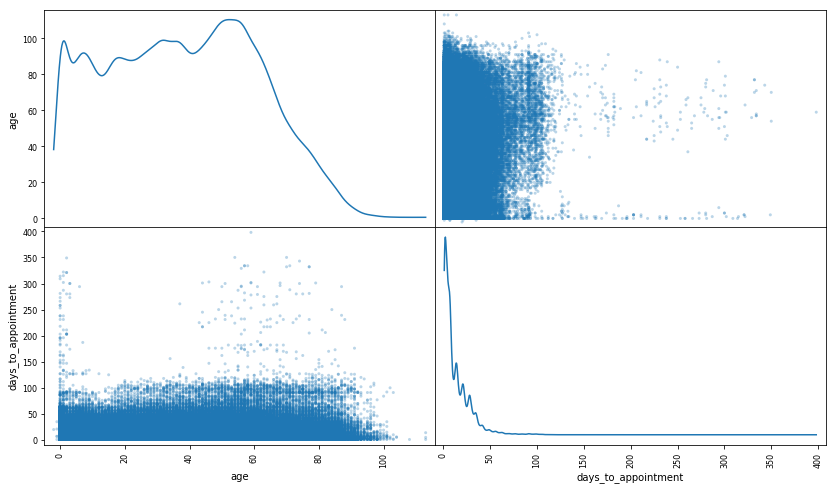

In [5]:
pd.plotting.scatter_matrix(data[['age', 'days_to_appointment']], alpha = 0.3, figsize = (14,8), diagonal = 'kde')

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefa3f07fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fefa2562668>]], dtype=object)

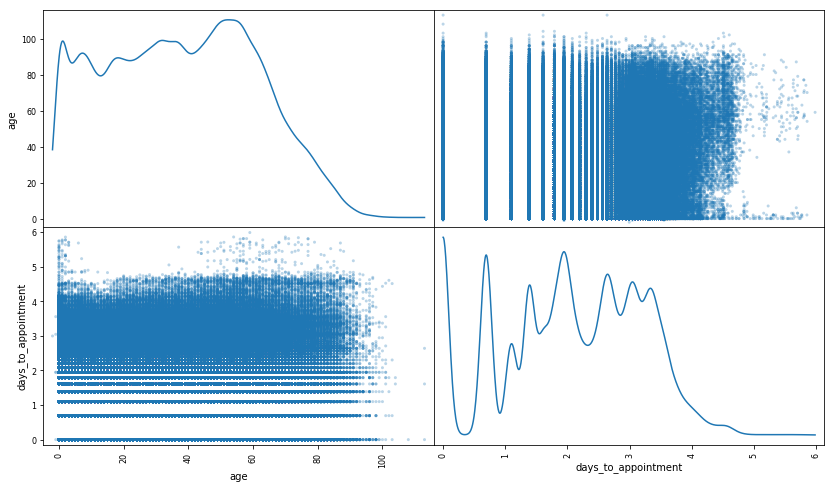

In [6]:
scatter_data = data[['age', 'days_to_appointment']]
scatter_data.loc[:, 'days_to_appointment'] = np.log(scatter_data.loc[:, 'days_to_appointment'])
pd.plotting.scatter_matrix(scatter_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

In [ ]:
outliers_indexes = {}

for feature in log_data.keys():
    Q1 = np.percentile(log_data[feature], 25)
    Q3 = np.percentile(log_data[feature], 75)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    outliers_data = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(outliers_data)
    for i in outliers_data.index.values:
        if i in outliers_indexes.keys():
            outliers_indexes[i].append(feature)
        else:
            outliers_indexes[i] = [feature]
            
repeated_indexes = {i:outliers_indexes[i] for i in outliers_indexes.keys() if len(outliers_indexes[i]) > 1}
print("Repeated Indexes:")
print(repeated_indexes)
    
outliers = list(repeated_indexes.keys()) + [66, 95, 96, 218, 338, 357]

good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

In [17]:
np.percentile(data['days_to_appointment'], 75) + (np.percentile(data['days_to_appointment'], 75) - np.percentile(data['days_to_appointment'], 25)) * 1.5

44.0

In [19]:
log_feature = np.log(data['days_to_appointment'])
Q1 = np.percentile(log_feature, 25)
Q3 = np.percentile(log_feature, 25)
step = (Q3 - Q1) * 1.5

data[(log_feature <= Q3 + step)]

,age,days_to_appointment,diabetes,alcoholism,hypertension,handicap,smokes,monetary_help,tuberculosis,sms_reminder,show_up,gender_f,gender_m,week_day_friday,week_day_monday,week_day_saturday,week_day_sunday,week_day_thursday,week_day_tuesday,week_day_wednesday
1,24,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
2,4,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
9,51,4,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0
15,73,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
17,52,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
19,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
20,33,3,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
21,44,2,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
22,5,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
23,69,4,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
